In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib


data_dir= "vehicles_images"

In [2]:
batch_size = 32
img_height = 160
img_width = 160

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

class_names = train_ds.class_names
print(class_names)

Found 4318 files belonging to 4 classes.
Using 3455 files for training.
Found 4318 files belonging to 4 classes.
Using 863 files for validation.
['bus', 'motorcycle', 'plane', 'train']


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# the pixels values are now in "[0,1]".
print(np.min(first_image), np.max(first_image))

num_classes = 4

0.0 1.0


In [4]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape = (img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        1

In [5]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

Epoch 1/10
108/108 [==============================] - 65s 597ms/step - loss: 1.1805 - accuracy: 0.4836 - val_loss: 1.0807 - val_accuracy: 0.5527
Epoch 2/10
108/108 [==============================] - 62s 571ms/step - loss: 0.9699 - accuracy: 0.5997 - val_loss: 0.9238 - val_accuracy: 0.6350
Epoch 3/10
108/108 [==============================] - 67s 623ms/step - loss: 0.8512 - accuracy: 0.6588 - val_loss: 0.9392 - val_accuracy: 0.6118
Epoch 4/10
108/108 [==============================] - 75s 692ms/step - loss: 0.6997 - accuracy: 0.7326 - val_loss: 0.9537 - val_accuracy: 0.6037
Epoch 5/10
108/108 [==============================] - 85s 786ms/step - loss: 0.5282 - accuracy: 0.7954 - val_loss: 1.0515 - val_accuracy: 0.5968
Epoch 6/10
108/108 [==============================] - 74s 686ms/step - loss: 0.3777 - accuracy: 0.8625 - val_loss: 1.1769 - val_accuracy: 0.6037
Epoch 7/10
108/108 [==============================] - 77s 713ms/step - loss: 0.2411 - accuracy: 0.9216 - val_loss: 1.3055 - val_ac

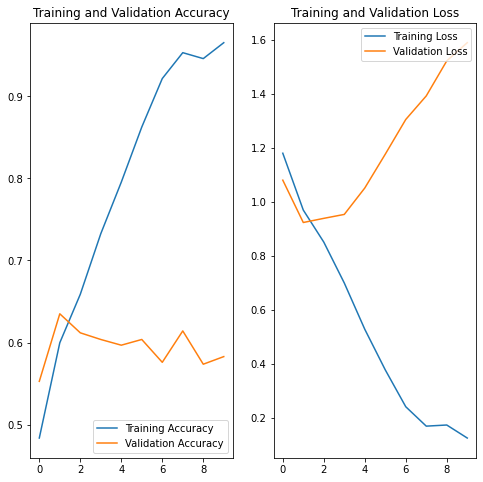

In [6]:
plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

(32, 160, 160, 3)
(32,)


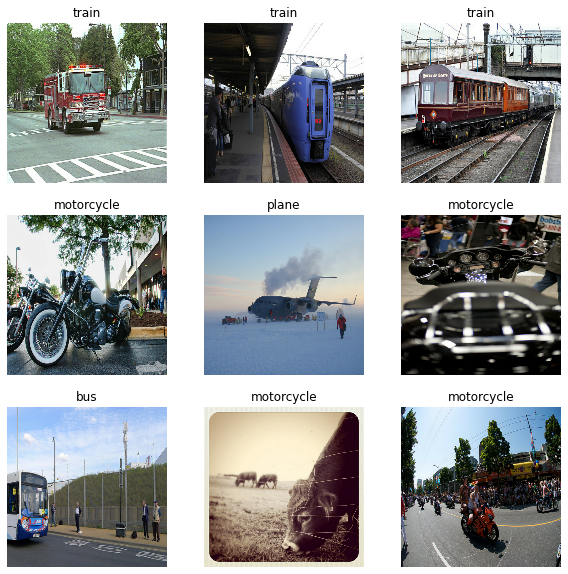

In [7]:
#confirming the format of our images and transforming back to images


import matplotlib.pyplot as plt

plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

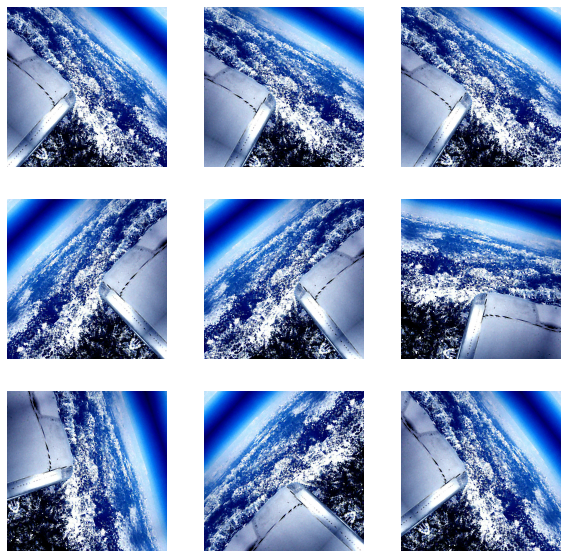

In [8]:
#Data Augmentation

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_ds.take(1):
    plt.figure(figsize = (10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [9]:
#using a pre-trained ImageNet model for feature extraction

#Create the base model from the pre-trained model MobileNet V2
IMG_SIZE= (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape = IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

9420800/9406464 [==============================] - 10s 1us/step
(32, 5, 5, 1280)


In [10]:
#developing the base model
base_model.trainable = False
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [11]:
#Addin prediction layer

prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [12]:
#Preprocessing the input

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [13]:
inputs = tf.keras.Input(shape = (160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training = False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

model.summary()

len(model.trainable_variables)

initial_epochs = 10
loss0, accuracy0 = model.evaluate(val_ds)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


history = model.fit(train_ds,
                    epochs = initial_epochs,
                    validation_data = val_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

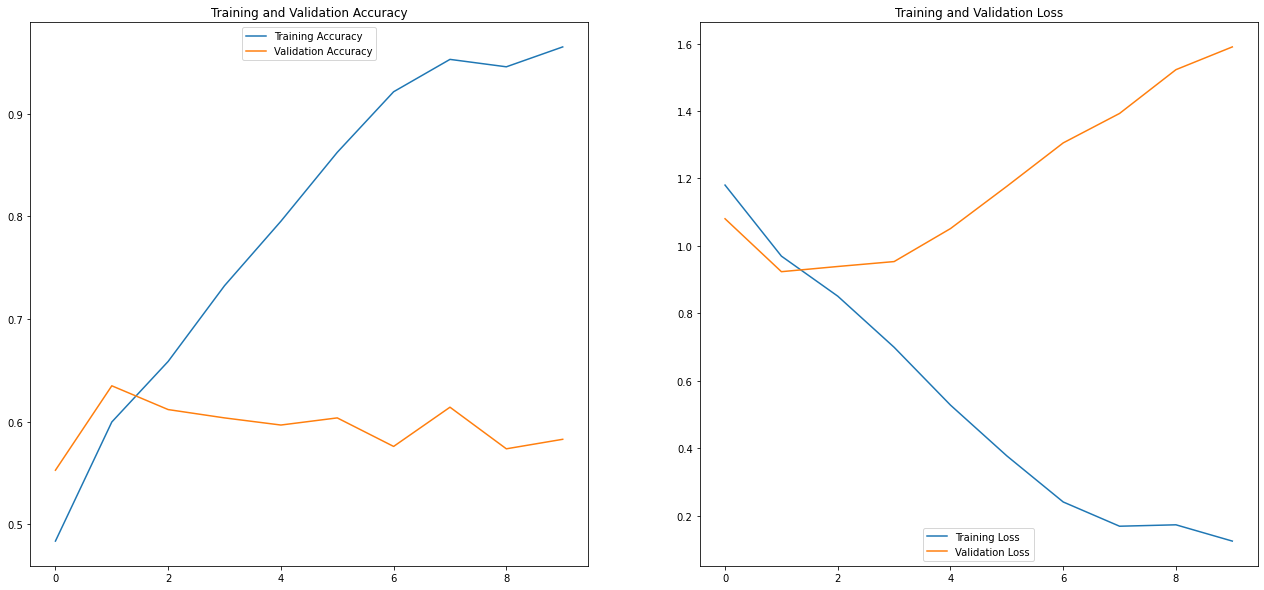

In [15]:
plt.figure(figsize = (22, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'upper center')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower center')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
#Fine tuning the model weights from a pre-trained model

base_model.trainable = True
base_model.summary()

#Checking for the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

#Fine-tune from this layer onwards
fine_tune_at = 100

#Freeze all the layers before 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [17]:
#Training the top layers of our model while retaining the generic layers as they are
#Unfreezing the base model and resume training from the specified layers; Fine-tuning our weights
#To do this, we have to re-compile our model

base_learning_rate = 0.0002
model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = base_learning_rate/10),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

In [18]:
# Adding fine-tuning epochs to our training epochs

initial_epochs = 10   #normal epochs from extracted features
fine_tune_epochs = 10  #extra for further fine-tuning
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds)

Epoch 10/20
108/108 [==============================] - 125s 1s/step - loss: 0.6679 - accuracy: 0.7404 - val_loss: 0.5528 - val_accuracy: 0.8019
Epoch 11/20
108/108 [==============================] - 107s 992ms/step - loss: 0.5935 - accuracy: 0.7632 - val_loss: 0.5085 - val_accuracy: 0.8088
Epoch 12/20
108/108 [==============================] - 107s 987ms/step - loss: 0.5460 - accuracy: 0.7925 - val_loss: 0.4788 - val_accuracy: 0.8216
Epoch 13/20
108/108 [==============================] - 110s 1s/step - loss: 0.5059 - accuracy: 0.7991 - val_loss: 0.5024 - val_accuracy: 0.8169
Epoch 14/20
108/108 [==============================] - 118s 1s/step - loss: 0.4831 - accuracy: 0.8229 - val_loss: 0.4956 - val_accuracy: 0.8273
Epoch 15/20
108/108 [==============================] - 108s 1s/step - loss: 0.4554 - accuracy: 0.8208 - val_loss: 0.4823 - val_accuracy: 0.8169
Epoch 16/20
108/108 [==============================] - 110s 1s/step - loss: 0.4426 - accuracy: 0.8318 - val_loss: 0.4982 - val_acc

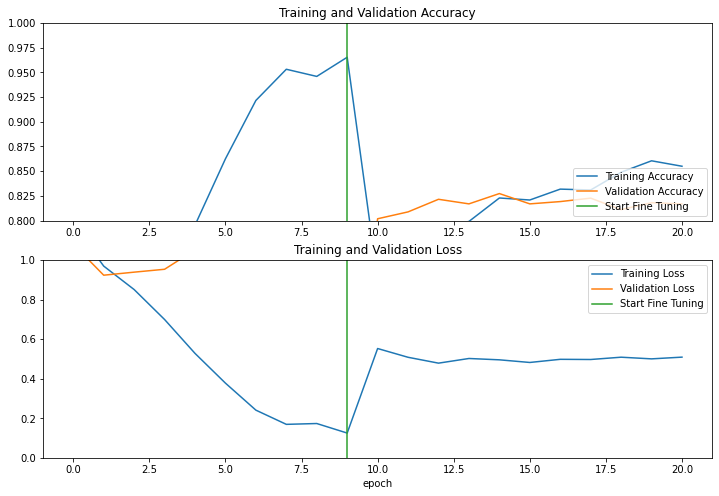

27/27 [==============================] - 15s 569ms/step - loss: 0.5092 - accuracy: 0.8169
Test accuracy:  0.8169177174568176


In [19]:
#The Plots after the fine-tunning
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['val_loss']

plt.figure(figsize = (12, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

loss, accuracy = model.evaluate(val_ds)
print('Test accuracy: ', accuracy)

In [29]:
data_test = 'new_data_set'

In [30]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(data_test, shuffle = False, image_size = (img_height, img_width))

Found 22 files belonging to 4 classes.


In [31]:
predict = model.predict(val_data)

In [32]:
predict

array([[  4.0487285 ,  -2.0129173 ,  -2.5489228 ,   0.5366897 ,
         -6.253793  ],
       [  3.740551  ,  -1.9527825 ,  -2.6514761 ,  -0.7815005 ,
         -8.44494   ],
       [  4.3438115 ,  -3.3185549 ,  -1.2821889 ,   0.03099787,
         -8.003533  ],
       [  4.2297277 ,  -2.275393  ,  -2.628199  ,   0.30518234,
         -8.891539  ],
       [  2.9726315 ,  -2.6604655 ,  -2.3576043 ,   0.23427533,
         -9.990615  ],
       [ -1.5630108 ,   7.55893   ,  -0.12916872,  -2.0461135 ,
         -7.9169292 ],
       [ -0.33565855,   6.7946978 ,  -2.624528  ,  -1.6065394 ,
         -8.340977  ],
       [ -1.355707  ,   7.2673755 ,  -0.9307636 ,  -2.0195274 ,
         -6.881658  ],
       [ -0.26469588,   5.326346  ,  -2.718591  ,  -1.3629767 ,
         -7.688188  ],
       [ -0.95508045,   5.8433046 ,  -2.268018  ,  -1.4193035 ,
         -8.465143  ],
       [ -0.5062675 ,  -3.3465936 ,   6.382192  ,  -0.48961914,
         -9.250359  ],
       [ -1.4003161 ,  -3.9276488 ,   7.788

In [33]:
predict_class = np.argmax(predict, axis = 1)
[class_names[val] for val in predict_class]

['bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'motorcycle',
 'motorcycle',
 'motorcycle',
 'motorcycle',
 'motorcycle',
 'plane',
 'plane',
 'plane',
 'plane',
 'plane',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train',
 'train']

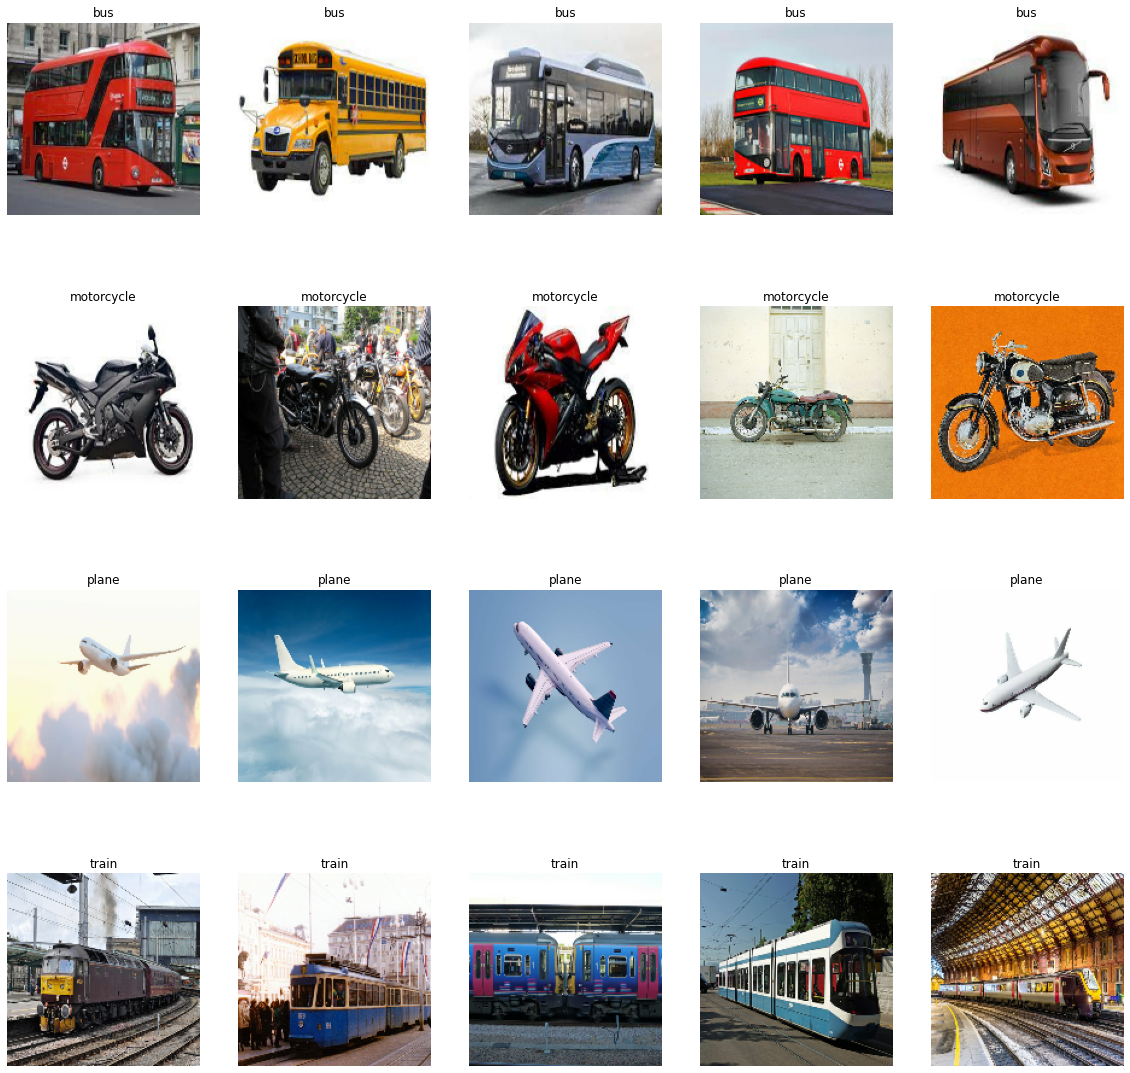

In [44]:
plt.figure(figsize=(20,20))
for images, label in val_data.take(1):
    for i in range(20):
        ax = plt.subplot(4,5, i + 1)
        plt.imshow(images[i]. numpy().astype('uint8'))
        plt.title(class_names[predict_class[i]])
        plt.axis('off')

In [36]:
for _, labels in val_data.take(1):
  print(labels)

tf.Tensor([0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 3 3], shape=(22,), dtype=int32)


In [37]:
val_val_classes  = [labels.numpy() for _, label in val_data.take(1)]

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
confusion = confusion_matrix(np.array(val_val_classes).reshape(20,1), pred_class)
plt.figure(figsize=(8,6))
sns.heatmap(confusion, annot = True, cmap = 'coolwarm', xticklabels= class_names, yticklabels = class_names)
